# Assembling the Analysis

This notebook accounts for periodic boundaries by shifting the whole grid & reclustering. Opposed to the first version, which just reclustered the boundaries.

The goal is to assemble routines for all parts of the analysis. These can than be combined into a script, which loops over a full data folder.

Development steps:
1. set up the periodic clustering
2. verify it works as intended (using pythyon testing functionalities?)
3. set up the analysis
4. define relevant I/O (one file per data set & one combination file)
5. set up the script

Content required for the analysis:
* mass distribution function for different theresholds
* bin mass as a function of radius -> desity profile
  (for every point compute distance to com & desnity)
* sphereicity: momentum of inertia
* mass versus radius

Possible radius definitions:
* 90% mass from the density profile
* $r = \sqrt{\sum_i m_i r_i^2 / \sum_i m_i}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function

from sklearn.cluster import DBSCAN
from sklearn import metrics

from random import randint
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist

import time
import sys
import h5py

from math import pow
from math import ceil

from numba import jit

from numpy import linalg as LA

## 1. Routines for periodic clustering

### Parameter definition
these schould later be part of the class

In [2]:
# DBSCAN parameters -> same for all executions
eps=2
min_samples=20
algorithm='kd_tree'
n_jobs=-1

# problem specific parameters
dens_th = 5
#data_file = '../data/density_maps/L=2, 1024-_128(WKB)/axion.r.00076'
data_file = '../data/density_maps/L=3, 1536 -_ 256(WKB)/axion.r.00038'

### a quick investiagtion of javiers data files

this doesn't need to go in the code but is for my reference

In [3]:
def check_hdf5_content(filename):
    
    file = h5py.File(filename, 'r')

    for item in file.attrs.keys():
        print(item + ":", file.attrs[item])
    print(' ')
    
    for item in file.keys():
        print(item + ":", file[item].keys())
        
    file.close()

In [10]:
file = h5py.File(data_file, 'r')
x = file.attrs[u'nQcd']
print(x)

7.0


In [4]:
check_hdf5_content('../data/density_maps/L=2, 1024-_128(WKB)/axion.r.00076')

Field type: Axion
Precision: Single
Size: 256
Depth: 256
Lambda: 15000.0
nQcd: 7.0
Physical size: 2.0
z: 5.0
zInitial: 0.5
zFinal: 5.0
nSteps: 2
Current step: 7600
 
energy: [u'density']


In [5]:
check_hdf5_content('../data/density_maps/L=3, 1536 -_ 256(WKB)/axion.r.00038')

Field type: Axion
Precision: Single
Size: 256
Depth: 256
Lambda: 15000.0
nQcd: 7.0
Physical size: 3.0
z: 6.0
zInitial: 0.5
zFinal: 6.0
nSteps: 5
Current step: 3800
 
energy: [u'density']


In [9]:
check_hdf5_content('../data/density_maps/L=3, 1536 -_ 256(WKB)/axion.r.00039')

Field type: Axion
Precision: Single
Size: 256
Depth: 256
Lambda: 15000.0
nQcd: 7.0
Physical size: 3.0
z: 5.0
zInitial: 0.5
zFinal: 5.0
nSteps: 5
Current step: 3900
 
energy: [u'density']


In [10]:
check_hdf5_content('../data/density_maps/L=3, 1536 -_ 256(WKB)/axion.r.00039_2')

Field type: Axion
Precision: Single
Size: 256
Depth: 256
Lambda: 15000.0
nQcd: 7.0
Physical size: 3.0
z: 6.0
zInitial: 0.5
zFinal: 6.0
nSteps: 5
Current step: 3900
 
energy: [u'density']


### read in the data file
this should become part of the constructor

ToDo:
* is the reshape command I found in Javiers code necessary
* n, n2, n3, sizeL should become class members

In [162]:
# new style data -> taken from javiers code
file = h5py.File(data_file, 'r')

n = file.attrs[u'Size']
sizeL = file.attrs[u'Physical size']

n2 = n*n
n3 = n2*n

print('# of grid points per direction: %d' %(n))
print('physical size of the grid: %d' %(sizeL))

# is the reshape necessary?
#print (data.shape)
data = file['energy/density'].value.reshape(n3)
#print (data.shape)
file.close()

# of grid points per direction: 256
physical size of the grid: 3


### extract relevant information
this should become a method for the class (requiring only the density thereshold as input parameter)
it could write the results to a sub-class, i.e. you create one class which holds general information & several sub-classes for every density thereshold

return values:
* \# of points above thereshold
* positin array of
* array of densities
* massfraction above thereshold

possible tests:
* array of densities can't contain points below thereshold
* test with created data that the locations are correct & the mass fraction

In [224]:
def basicstuff(data, dens_th) : 
    
    # mask all points below the density thereshold
    mask = ( data > dens_th)
    
    # create three arrays containing the x, y, and z position of every point on the full grid
    bas = np.zeros((n,n,n),dtype=float)
    linap = np.arange(0,n,dtype=float).reshape((n,1,1))
    x_pos = bas + linap
    y_pos = bas + linap.reshape((1,n,1))
    z_pos = bas + linap.reshape((1,1,n))
    del bas, linap
    x_pos = np.reshape(x_pos,(n3,))
    y_pos = np.reshape(y_pos,(n3,))
    z_pos = np.reshape(z_pos,(n3,))

    # create an empty array to hold the positions
    npo = len(x_pos[mask])
    pos = np.empty((npo,3))
    
    # apply mask to only get the positions above thereshold
    # write to position array
    pos[:,0] = x_pos[mask]
    pos[:,1] = y_pos[mask]
    pos[:,2] = z_pos[mask]
    
    #apply mask to get the density array
    den = data[mask]
    
    fractionofmass = np.add.reduce(den)/n3
    print('for thereshold %d: returned %d points containing %.1f/100 of the mass'%(dens_th, npo,100*fractionofmass))
    return npo, pos, den, fractionofmass

In [225]:
npo, pos, den, massfraction = basicstuff(data, dens_th)

for thereshold 5: returned 305979 points containing 16.1/100 of the mass


### plot the data above thereshold

this is just a crosscheck
-> decide if it should be part of the final code

In [165]:
def plot_all_positions(pos):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(0, n)
    ax.set_ylim3d(0, n)
    ax.set_zlim3d(0, n)
    ax.scatter(pos[:,0], pos[:,1], pos[:,2], s=6, lw=0)

    plt.show()

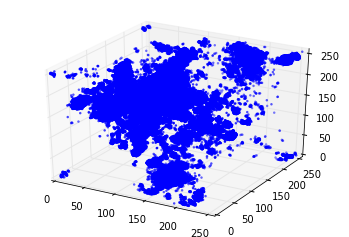

In [9]:
plot_all_positions(pos)

### obtain the labels

In [226]:
# 1. cluster the original data set
start = time.time()
db = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos)
labels = np.array(db.labels_)
end = time.time()
nmc1 = len(set(labels))
print('clustering original data set returned %d clusters and took %1.3f s' %(nmc1,end-start))

nh = n//2

# 2. shift the data by n/2 and take mod(n)
pos2 = (pos + [nh,nh,nh])%n

# 3. cluster the shifted data set
start = time.time()
db2 = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos2)
labels2 = np.array(db2.labels_)
nmc2 = len(set(labels2))
end = time.time()
print('clustering shifted data set returned %d clusters and took %1.3f s' %(nmc2,end-start))

clustering original data set returned 316 clusters and took 8.345 s
clustering shifted data set returned 317 clusters and took 8.253 s


### Plot the clustered data

In [10]:
def plot_clusters_3D (pos, labels):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(0, n)
    ax.set_ylim3d(0, n)
    ax.set_zlim3d(0, n)

    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        if (k>-1):

            class_member_mask = (labels == k)
            xyz = pos[class_member_mask] #list of coordinates of all points in one cluster

            ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=col, s=6, lw=0)

    plt.show()

In [11]:
def plot_individual_cluster(pos, masslabels, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(0, n)
    ax.set_ylim3d(0, n)
    ax.set_zlim3d(0, n)

    class_member_mask = (masslabels == label)
    xyz = pos[class_member_mask]

    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], s=6, lw=0)

    plt.show()

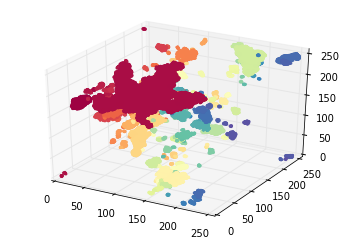

In [14]:
plot_clusters_3D(pos,labels)

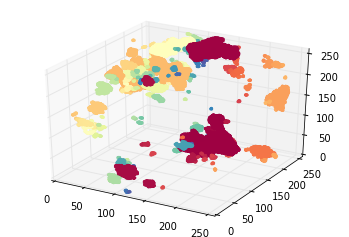

In [20]:
plot_clusters_3D(pos2,labels2)

### account for periodic boundaries

needed tests:
* try with mock data: is the number of clusters etc found correctly
* try with random data sets: after the relabeling process a second shift should not have any effect
* test with mock data if clusters in set 2 but noise in set1 are accounted for correctly
* in any case newlabes should not conatin any -2 entries

we can think of implementing the second test as part of the code for every data set depending on how much time it takes

To Do:
* rename the sex-function
* print out the final number of clusters found
* what ammount of points is noise?

In [227]:
def sex (labels,labels2):
    
    npo = len(labels)
        
    # 1. create auxilliary label arrays
    # conventions: points already visited are -2 in labels11, labels22
    #              points not visited yet are -2 in newlabels
    newlabels = np.zeros(npo,dtype=int) -2
    labels11 = np.zeros(npo,dtype=int)
    labels22 = np.zeros(npo,dtype=int)
    
    labels11[:] = labels
    labels22[:] = labels2
    
    # account for all points which are marked as noise in both datasets
    parla1 = (labels  == -1)
    parla2 = (labels2 == -1)

    newlabels[parla1*parla2]   = -1
    labels11[parla1*parla2] = -2
    labels22[parla1*parla2] = -2
  
    # 2. create a list with the first index at which a label appears
    m1 = max(labels)
    jta = np.arange(0,npo,dtype=int)

    po1 = []
    for j in set(labels):
        if j > -1:
            parla1 = (labels  == j)
            po1.append(jta[parla1][0])
    po1 = np.array(po1)
       
    # 3. loop over all clusters found in set1
    dicta = []    
    for i in set(labels): 
        if i > -1:
            # reference point
            posi = po1[i]
            ll = labels[posi]
            
            # get the cluster of this point in both labeling systems
            parla1 = (labels  == ll)
            parla2 = (labels2 == labels2[posi])
               
            # if the point labels two clusters, group them
            if labels2[posi] > -1 :
                mask = np.logical_or(parla1,parla2)
                seta = np.array(list(set(newlabels[mask])))
                seta = seta[seta > -1]
                               
                # actually some of the points found may already be part of a cluster
                # account for all points in that cluster
                # changed from Javiers original code
                # if len(seta) > 1:
                if len(seta) > 0:
                    for lset in seta:
                        minimask = (newlabels == lset)
                        mask = np.logical_or(mask,minimask)
                    ll = min(seta)
                    
                newlabels[mask] = ll
                labels11[mask] = -2
                labels22[mask] = -2
                                
            # if the point belongs to a mc in case 1 but not in case 2:
            # only take the points from case 1 & edit in newlabels
            # the opposite case is accounted for below
            elif labels2[posi] == -1 :
                mask = parla1 
                newlabels[mask] = ll
                labels11[mask] = -2
            
            # store information about which labels have been grouped together
            dicta.append([labels[posi],labels2[posi],ll])
        
            
    maxrelab = max(newlabels)

    # 4. account for points which are noise in set1 but belong to a cluster in set2
    rela2 = np.array(list(set(labels22)))

    counter = 0
    
    for j in rela2:
        if j > -1 :
            # must anypoint of this MC need be asssotiated with a mc already present in newlabels?
            # changed from Javiers initial code
            # asolabel = np.array(list(set(labels2[parla22])))
            # parla22 = (labels22  == j)
            parla22 = (labels2 == j)
            asolabel = np.array(list(set(newlabels[parla22])))
            asolabel = asolabel[asolabel > -1]
            
            ll2 = j
            
            # changed from Javiers original code:
            #if asolabel == []
            print(asolabel)
            #if not asolabel.any():
            if len(asolabel) == 0:
                # changed from Javiers initial code
                # first increase the counter THEN assign the label
                print ('x')
                counter +=1 
                newlabels[parla22] = maxrelab + counter
                dicta.append([-1,ll2, maxrelab + counter])
                
            elif len(asolabel) > 0:
                lala = min(asolabel)

                for l in asolabel:
                    para = (newlabels == l)
                    newlabels[para] = lala
                    dicta.append([-1,j, lala])
                newlabels[parla22] = lala
                
            labels11[parla22] = -2
            labels22[parla22] = -2    

    print('crosscheck: # of points not visited by the function: %d' %(sum(newlabels==-2)))
    print('final number of clusters found: %d' %(len(set(newlabels))))
    return newlabels, list(dicta)


In [228]:
newlabels, dicta = sex(labels,labels2)

[1]
[139]
[]
x
[]
x
[120]
[134]
[130]
[203]
[109]
[132]
[109]
[133]
[116]
[116]
crosscheck: # of points not visited by the function: 0
final number of clusters found: 294


### print the clustered distribution

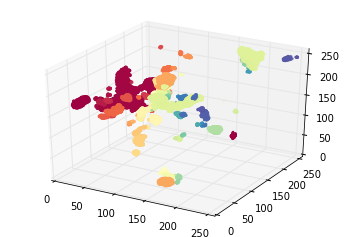

In [179]:
plot_clusters_3D(pos, newlabels)

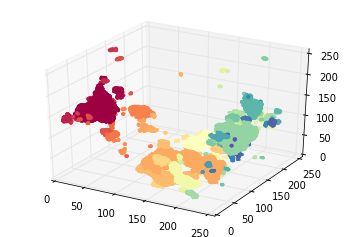

In [24]:
plot_clusters_3D(pos, labels)

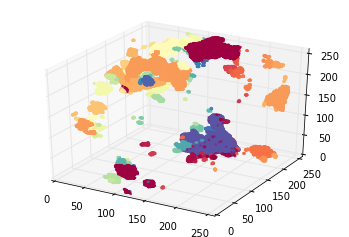

In [25]:
plot_clusters_3D(pos2, newlabels)

## 2. Analysis of one data set

### relabel according to mass and number of points

In [229]:
def getMass(it):
    return it[1]

def getNumb(it):
    return it[2]

def relabelMN(newlabels,den):
    
    # 1. create a list containing the label, mass(= sum of densities) and number of points
    minilabels = np.array(list(set(newlabels)))
    poso = []
    for l in minilabels:
        if l > -1:
            class_member_mask = (newlabels == l)
            poso.append( [l ,np.add.reduce(den[class_member_mask]), np.add.reduce(class_member_mask)] )
    
    # 2. sort the lists
    oroM = sorted(poso,key=getMass)
    oroN = sorted(poso,key=getNumb)

    # 3. create two new arrays for the labels
    numberoflabels = len(oroM)
    masslabels = np.empty_like(newlabels)
    numblabels = np.empty_like(newlabels)

    # noise 
    masslabels[:] = newlabels[:]
    numblabels[:] = newlabels[:]

    
    counter = 0 

    # 4. assign labels ordered by mass
    for i in range(0,numberoflabels):
        para = (newlabels == oroM[i][0])
        masslabels[para] = numberoflabels-i-1

    # 5. assign labels ordered by number of points
    for i in range(0,numberoflabels):
        para = (newlabels == oroN[i][0])
        numblabels[para] = numberoflabels-i-1
    
    return masslabels, numblabels

In [230]:
masslabels, numblabels = relabelMN(newlabels,den)

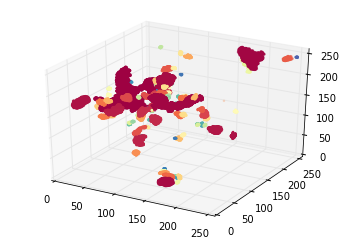

In [182]:
plot_clusters_3D(pos, masslabels)

### build a table with MC properties

output parameters:
* mass of each cluster
* number of points of each cluster
* radius for each cluster accoring to the following definitions:
    * r1 = 1/2 of the maximum distance to the COM
    * r2 = $\left(\sum_i r_i^2 m_i/\sum m_i \right)^{1/2}$
    * r3 = $\sim_i r_i m_i/ \sum m_i$
    * r4: radius enclosing 90% of the mass
* momentum of inertia as a meassure of sphericity

ToDo:
* turn the output array into a dictiuonary

In [231]:
def reshift_to_1(label, masslabels, pos):
    # this function is to be called from sosa
    
    # 1. extract positions of the affected cluster
    cordi = pos[masslabels == label]
    
    # 2. iterate over directions
    #shift_vector = [0,0,0]
    shift_vector = np.zeros(3)
    for axis in range(0,3):
        
        # 2.a) get the set of coordinates in one direction
        coordinates_1d = sorted(set(cordi[:,axis]))
                
        # 2.b) check if the direction needs a shift
        if coordinates_1d[0] == 0 and coordinates_1d[-1] == n-1:
            print('label: %3d, crossing axis %d' %(label, axis))
            #2.c) find the right magnitude for the shift
            # all coordinates which are not in the list
            free_points = [x for x in xrange(0,n) if x not in coordinates_1d]
            
            found_free_plane = False
            counter = len(free_points)-1
            while not found_free_plane:
                shift = free_points[counter]
                
                # we require that the shifted grid has no cluster on any boundaries!
                if (shift-1) == free_points[counter-1]:
                    shift_vector[axis] = n-shift
                    found_free_plane = True
                else:
                    counter = counter-1
                if counter==0:
                    print('Trying to shift the cluster with masslabel %d:' %(label))
                    print('FAILED: could not find a free plane in direction %d.' %(axis))
                    print('excluding the cluster from the analysis')
                    return []
                
    # 3. apply all three shifts to the cluster
    cordi = np.add(cordi, shift_vector)%n
    
    return cordi, shift_vector             

In [232]:
def sosa(masslabels, den, labels, labels2, pos, pos2):
    
    dapa =[]
    pain =[]
    mcl_it = set(masslabels)
    mcl_it.discard(-1)
    
    for mcl in mcl_it:
        
        cordi, v = reshift_to_1(mcl, masslabels, pos)

        # 2.c) check if the cluster contains more than one point
        # this is not the case when reshift_to_1 fails to find an appropriate plane
        if len(cordi) > 1: 
            
            # 2.d) get mass and number of points
            lden  = den[masslabels == mcl]
            masa  = np.add.reduce(lden)
            numb  = np.add.reduce(masslabels == mcl)

            # 2.e) compute the center of motion & place it in the origin
            momi = np.empty_like(cordi)
            relcor = np.empty_like(cordi)
            momi[:,0] = lden*cordi[:,0]
            momi[:,1] = lden*cordi[:,1]
            momi[:,2] = lden*cordi[:,2]
            com1 = np.add.reduce(momi)/(masa) 
            relcor = cordi - com1 
            
            # 2.f) compute radius (3 different definitions)
            radii = LA.norm(relcor,axis=1)
            top = int(max(radii) ) + 1 
            r1 = max(radii)/2
            r2 = (np.add.reduce(radii*radii*lden)/masa)**0.5
            r3 = np.add.reduce(radii*lden)/masa

            # 2.g) the density profile
            bins=range(0,top)
            bin_d = (np.histogram(radii, bins, weights=lden)[0])
            ms = np.cumsum(bin_d/masa)
            ms = np.append(ms,1.)

            # 2.h) radius which includes 90% of the density
            per1 = 0.9
            rad = np.arange(0,len(ms))
            low = ms[ms<per1][-1]
            rr1 = rad[ms<per1][-1]
            hig = ms[ms>per1][0]
            rr2 = rad[ms>per1][0]
            r4 = rr1 + (per1-low)*(rr2-rr1)/(hig-low)

            # 2.i) a meassure for sphericity
            misa = np.identity(3)*0
            for i in range(0,len(relcor)):
                fus = relcor[i]
                misa = misa + lden[i]*(np.dot(fus,fus)*np.identity(3) - np.outer(fus,fus))
            maino = np.sqrt(LA.eigvalsh(misa)/masa)

            dapa.append([masa,r1,r2,r3,r4,numb])
            pain.append(maino)
                
        else:
            print('WARNING: the cluster with label %d contains 0 or 1 points' %(mcl))
            print('either the function reshift_to_1 failed or your clustering is erronous!')
            
    dapa = np.array(list(dapa))
    pain = np.array(list(pain))
    return dapa, pain

In [233]:
dapa, pain = sosa(masslabels, den, labels, labels2, pos, pos2)

label:   0, crossing axis 1
label:   0, crossing axis 2
label:   1, crossing axis 1
label:   2, crossing axis 0
label:  10, crossing axis 1
label:  15, crossing axis 1
label:  30, crossing axis 0
label:  30, crossing axis 2
label:  41, crossing axis 0
label:  44, crossing axis 0
label:  66, crossing axis 2
label:  69, crossing axis 1
label:  74, crossing axis 2
label:  80, crossing axis 1
label:  96, crossing axis 2
label: 110, crossing axis 1
label: 113, crossing axis 2
label: 124, crossing axis 2
label: 148, crossing axis 1
label: 157, crossing axis 1
label: 159, crossing axis 1
label: 167, crossing axis 1
label: 170, crossing axis 2
label: 181, crossing axis 2
label: 194, crossing axis 1
label: 214, crossing axis 2
label: 246, crossing axis 1
label: 275, crossing axis 0


In [57]:
len(dapa)

293

In [59]:
len(dapa[:,1])

293

### mass vs radius plot

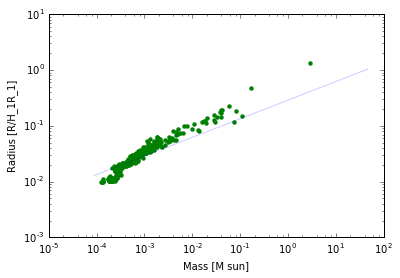

In [245]:
delta = sizeL/n
#unitmass = 2e-13 * (delta)**3
unitmass = (delta)**3
labeled = []

fig = plt.figure()
ax = fig.add_subplot(111)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Radius [R/H_1R_1]')
plt.xlabel('Mass [M sun]')

#ax.set_xlim(.5*unitmass*min(dapa[:,0]),2*unitmass*max(dapa[:,0]))
#ax.set_ylim(.5*delta*min(dapa[:,3]),2*delta*max(dapa[:,3]))

plt.scatter(unitmass*dapa[:,0],delta*dapa[:,4], c='green', lw=0)
for mc in labeled:
        ax.annotate('%d' % mc, xy=(unitmass*dapa[mc,0],delta*dapa[mc,3]), textcoords='data') # <--

midpoint = len(dapa)//2 
r_mid = delta*np.mean(dapa[midpoint,3])
m_mid = unitmass*np.mean(dapa[midpoint,0])
x = delta*np.linspace(min(dapa[:,3]),max(dapa[:,3]),10)
plt.plot( m_mid*(x/r_mid)**3., x, c='blue', alpha=0.2)

plt.show()

### Eccentricity
Take the three inertia of motion (corresponding to three spatial directions) and plot (min-max)/(min+max). For a perfect sphere this is zero.

Note: the three inertia of motions are computed from the eigenvalues and should be independent of basis rotations!

ToDo:
* assign some meaning to this (values for an ellipsoid, pick some examples)
* is there a connection between sphericity and mass

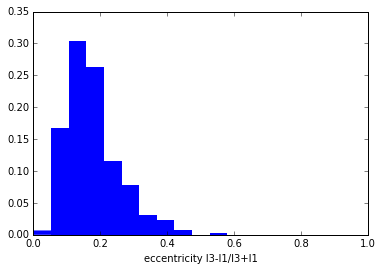

In [236]:
ecc = []
for i in range(0,len(pain)):
    mix = min(pain[i])
    man = max(pain[i])
    ecc.append((man-mix)/(man+mix))
    # print(mix, man)
    
weights = np.ones_like(ecc)/float(len(ecc))
plt.hist(ecc,bins=np.linspace(0,1,20), lw=0, weights=weights)
#for item in p:
#    item.set_height(item.get_height()/sum(x))
plt.xlabel('eccentricity I3-I1/I3+I1')
plt.show()

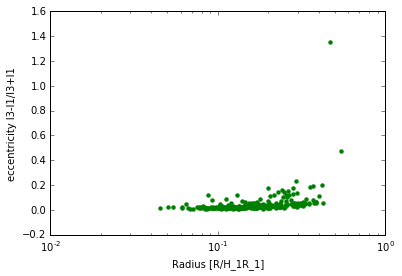

In [237]:
ecc = []
for i in range(0,len(pain)):
    mix = min(pain[i])
    man = max(pain[i])
    ecc.append((man-mix)/(man+mix))

fig = plt.figure()
ax = fig.add_subplot(111)

#plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [R/H_1R_1]')
plt.ylabel('eccentricity I3-I1/I3+I1')

#ax.set_xlim(5e-18,2e-13)
#ax.set_ylim(5e-3,.5)

plt.scatter(ecc,delta*dapa[:,4], c='green', lw=0)
plt.show()

### Mass function

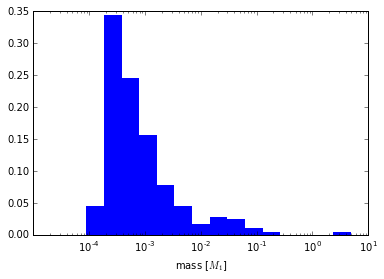

In [238]:
delta = sizeL/n
mass = delta**3*dapa[:,0]
weights = np.ones_like(mass)/float(len(mass))
plt.xscale('log')
plt.xlabel('mass [$M_1$]')
plt.hist(mass,bins=np.logspace(-5,1,20), lw=0,weights=weights)
plt.show()

### density profile

* compute com
* for every point in the cluster: compute it's distance from the COM
* for every distance bin compute $\sum_i \rho_i / \sum_i$

In [33]:
# get the full grid and all densities!
npo_A, pos_A, den_A, massfraction_A = basicstuff(data, 0)

for thereshold 0: returned 16614048 points containing 100.0/100 of the mass


In [239]:
def density_profile(label, radius, masslabels, pos, dens, pos_A, den_A):
     
    # compute the COM & possible coordinate shift
    com1, shift_vec = cluster_com(pos, masslabels, label)
        
    # define the maximum radius
    rmax = 1.5*radius
    
    # shift the full grid so the COM is in the middle (at [n/2 n/2 n/2])
    tmp_vec = np.ones(3)*float(n//2)
    shift_vec = shift_vec + tmp_vec - com1
    pos_red = np.add(pos_A, shift_vec)%n
    
    # only keep a square around the com
    # this only serves for data reduction
    tmp_vec_min = np.ones(3)*(n//2 - rmax)
    tmp_vec_max = np.ones(3)*(n//2 + rmax)
    
    # if the cluster is too big take the whole grid
    if any(tmp_vec_min < 0) or any(tmp_vec_max > (n-1)):
        tmp_vec_min[:] = 0
        tmp_vec_max[:] = n-1
    
    map_square = np.all(np.greater(pos_red,tmp_vec_min),axis=1)*(np.all(np.less(pos_red,tmp_vec_max),axis=1))
    pos_red = pos_red[map_square]
    den_red = den_A[map_square]
    
    # compute distance to the COM
    tmp_vec = np.ones(3)*float(n//2)
    radii = LA.norm(pos_red-tmp_vec,axis=1)
        
    nbin = 10
    density_profile = np.zeros(nbin)
    radii_profile = np.zeros(nbin)
    sum_points = 0
    sum_den = 0
    
    for rbin in range (0,nbin):
        b_min = (rbin)/float(nbin)*rmax
        b_max = (rbin+1)/float(nbin)*rmax
        
        # for small mcs the innermost radius is too small!
        map_bin = (radii>b_min)*(radii<b_max)
        if np.add.reduce(map_bin) > 0:
            sum_points += np.add.reduce(map_bin)
            sum_den += np.add.reduce(den_red[map_bin])
                
            density_profile[rbin] = sum_den/sum_points
            radii_profile[rbin] = b_max/radius
        
    return density_profile, radii_profile

In [240]:
np.set_printoptions(threshold=100)

In [241]:
start = time.time()
profile0, bin0 = density_profile(0, dapa[0,4], masslabels, pos, den, pos_A, den_A)
profile1, bin1 = density_profile(1, dapa[1,4], masslabels, pos, den, pos_A, den_A)
profile2, bin2 = density_profile(2, dapa[2,4], masslabels, pos, den, pos_A, den_A)
profile3, bin3 = density_profile(3, dapa[3,4], masslabels, pos, den, pos_A, den_A)
profile4, bin4 = density_profile(4, dapa[4,4], masslabels, pos, den, pos_A, den_A)
print('computing the density profile took %f' %(time.time()-start))

label:   0, crossing axis 1
label:   0, crossing axis 2
label:   1, crossing axis 1
label:   2, crossing axis 0
computing the density profile took 16.583306


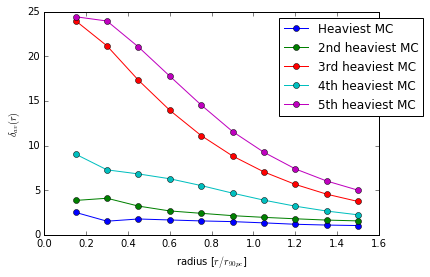

In [246]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel('radius [$r/r_{90pc}$]')
plt.ylabel('$\delta_{av}(r)$')

plt.plot(bin0, profile0, marker='o', label='Heaviest MC')
plt.plot(bin1, profile1, marker='o', label='2nd heaviest MC')
plt.plot(bin2, profile2, marker='o', label='3rd heaviest MC')
plt.plot(bin3, profile3, marker='o', label='4th heaviest MC')
plt.plot(bin4, profile4, marker='o', label='5th heaviest MC')

legend = plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1)
#frame = legend.get_frame()
#frame.set_facecolor('white')
#frame.set_edgecolor('red')
#frame.set_linewidth(0)

plt.show()

### check those clusters which cross a boundary in both simulations
for data_file = '../data/density_maps/L=2, 1024-_128(WKB)/axion.r.00076' these are the ones with masslabels:

0, 1, 6, 12, 59, 72, 81, 93 ...

### compare the COM to the clusters location
for cluster with masslabel 0 the COM was printed out and inserted manually here!

-> projecting on a plane makes it more obvious what is going on!

label:   0, crossing axis 1
label:   0, crossing axis 2


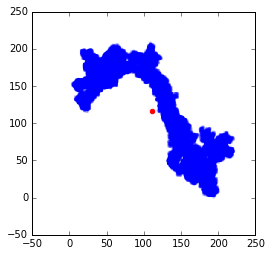

In [148]:
ppos, vec = reshift_to_1(0,masslabels,pos)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.axes().set_aspect('equal')
ax.scatter(ppos[:,0], ppos[:,1],alpha=.1,s=10,lw=0)
ax.scatter(111.04499431, 116.33095672, color='red')
plt.show()

### Plotting of the heaviest clusters

In [195]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerLine2D

In [196]:
def cluster_com(pos, masslabels, label):
    
    cordi, shift_vec = reshift_to_1(label, masslabels, pos)
    lden  = den[masslabels == label]
    
    # compute the COM (in reshifted coordinates)
    masa  = np.add.reduce(lden)
    momi = np.empty_like(cordi)
    momi[:,0] = lden*cordi[:,0]
    momi[:,1] = lden*cordi[:,1]
    momi[:,2] = lden*cordi[:,2]
    com1 = np.add.reduce(momi)/(masa)
    
    return com1, shift_vec

In [200]:
def plot_individual_cluster_withprojections(pos, masslabels, label, dapa):
    
    # com and radii
    com, v = cluster_com(pos, masslabels, label)
    r_half_max = dapa[label,1]
    r_mass_weighted = dapa[label,2]
    r_mass_90pc = dapa[label,4]
    
    # plotting environment
    gs = gridspec.GridSpec(3, 2, width_ratios=[3, 1])
    fig = plt.figure(figsize=(10,8))
        
    # 3D plot
    ax1 = fig.add_subplot(gs[0:2,0],projection='3d')
    xyz, v = reshift_to_1(label,masslabels,pos)
    ax1.set_xlim3d(min(xyz[:,0]), max(xyz[:,0]))
    ax1.set_ylim3d(min(xyz[:,1]), max(xyz[:,1]))
    ax1.set_zlim3d(min(xyz[:,2]), max(xyz[:,2]))
    ax1.scatter3D(xyz[:,0], xyz[:,1], xyz[:,2],lw=0,c='blue',depthshade='True',alpha=.1,rasterized=True)
    ax1.scatter(com[0],com[1],com[2],c='red',lw=0)


    # projection 1
    circle1 = plt.Circle((com[0],com[1]), r_half_max, color='black',lw=.2,fill=False )
    circle2 = plt.Circle((com[0],com[1]), r_mass_weighted, color='black',fill=False,lw=1,linestyle='--')
    circle3 = plt.Circle((com[0],com[1]), r_mass_90pc, color='black',fill=False,lw=1,linestyle=':')

    ax2 = fig.add_subplot(gs[0,1])
    ax2.scatter(xyz[:,0], xyz[:,1],lw=0,c='blue',alpha=.3,rasterized=True)
    ax2.scatter(com[0],com[1],c='red',lw=0,rasterized=True)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xlim([com[0]-2*r_half_max, com[0]+2*r_half_max])
    ax2.set_ylim([com[1]-2*r_half_max, com[1]+2*r_half_max])
    ax2.set_aspect('equal')
    ax2.add_artist(circle1)
    ax2.add_artist(circle2)
    ax2.add_artist(circle3)

    # projection 2
    circle1 = plt.Circle((com[0],com[2]), r_half_max, color='black',fill=False,lw=.2)
    circle2 = plt.Circle((com[0],com[2]), r_mass_weighted, color='black',fill=False,lw=1,linestyle='--')
    circle3 = plt.Circle((com[0],com[2]), r_mass_90pc, color='black',fill=False,lw=1,linestyle=':')

    ax3 = fig.add_subplot(gs[1,1])
    ax3.scatter(xyz[:,0], xyz[:,2],lw=0,c='blue',alpha=.1)
    ax3.scatter(com[0],com[2],c='red',lw=0)
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    ax3.set_xlim([com[0]-2*r_half_max, com[0]+2*r_half_max])
    ax3.set_ylim([com[2]-2*r_half_max, com[2]+2*r_half_max])
    ax3.set_aspect('equal')
    ax3.add_artist(circle1)
    ax3.add_artist(circle2)
    ax3.add_artist(circle3)

    # projection 3
    circle1 = plt.Circle((com[1],com[2]), r_half_max, color='black',fill=False,lw=.2)
    circle2 = plt.Circle((com[1],com[2]), r_mass_weighted, color='black',fill=False,lw=1,linestyle='--')
    circle3 = plt.Circle((com[1],com[2]), r_mass_90pc, color='black',fill=False,lw=1,linestyle=':')

    ax4 = fig.add_subplot(gs[2,1])
    ax4.scatter(xyz[:,1], xyz[:,2],lw=0,c='blue',alpha=.1)
    ax4.scatter(com[1],com[2],c='red',lw=0)
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    ax4.set_xlim([com[1]-2*r_half_max, com[1]+2*r_half_max])
    ax4.set_ylim([com[2]-2*r_half_max, com[2]+2*r_half_max])
    ax4.set_aspect('equal')
    ax4.add_artist(circle1)
    ax4.add_artist(circle2)
    ax4.add_artist(circle3)
    
    # description
    ax5 = fig.add_subplot(gs[2,0])
    ax5.axis('off')
    
    # radii
    label_r_half_max = 'half maximum radius = %1.2f $\\times H_1 R_1$' %(sizeL/n*r_half_max)
    line_r_half_max = mlines.Line2D([], [], color='black', lw=.2, label=label_r_half_max)
    label_r_mass_weighted = 'mass weighted radius = %1.2f $\\times H_1 R_1$' %(sizeL/n*r_mass_weighted)
    line_r_mass_weighted = mlines.Line2D([], [], color='black', lw=1,linestyle='--', label=label_r_mass_weighted)
    label_r_mass_90pc = 'radius enclosing 90%% of cluster mass  = %1.2f $\\times H_1 R_1$' %(sizeL/n*r_mass_90pc)
    line_r_mass_90pc = mlines.Line2D([], [], color='black', lw=1,linestyle=':', label=label_r_mass_90pc)
    
    # COM
    label_com = 'center of mass'
    line_com = mlines.Line2D([], [], c='red',lw=0, marker='o', label=label_com)
    #line_com = ax5.scatter([], [],c='red',lw=0,label=label_com)
    
    legend = plt.legend(handles=[line_r_half_max,line_r_mass_weighted, line_r_mass_90pc, line_com],
                        handler_map = {line_com: HandlerLine2D(numpoints=1)},
                        frameon=False)
    legend._legend_box.align = "left"
    
    # title
    if label==0:
        titlestring = 'Heaviest '
    elif label==1:
        titlestring = '2nd heaviest '
    elif label==2:
        titlestring = '3rd heaviest '
    else:
        titlestring ='%d th heaviest' %(label+1)
    titlestring += 'cluster found for a thereshold of %d .\n' %(dens_th)
    titlestring += 'Cluster mass: %1.2f $\\times M_1$, number of points: %d .' %((sizeL/n)**3*dapa[label,0], dapa[label,5])
    
    legend.set_title(titlestring,prop = {'size':'large'})
    
    gs.update(wspace=.1, hspace=.1)
    
    plt.show()

label:   1, crossing axis 1
label:   1, crossing axis 1


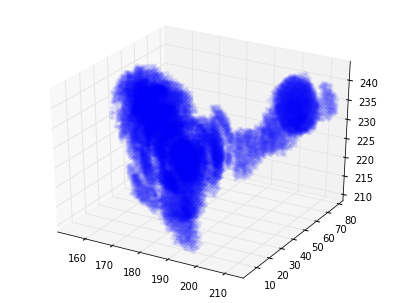

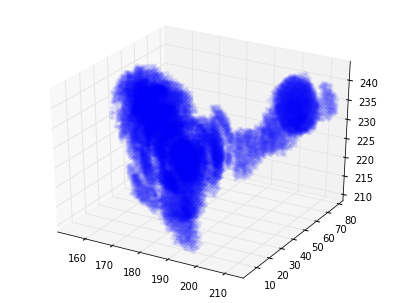

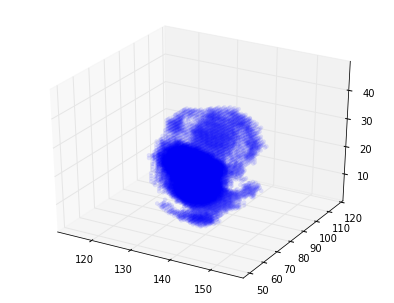

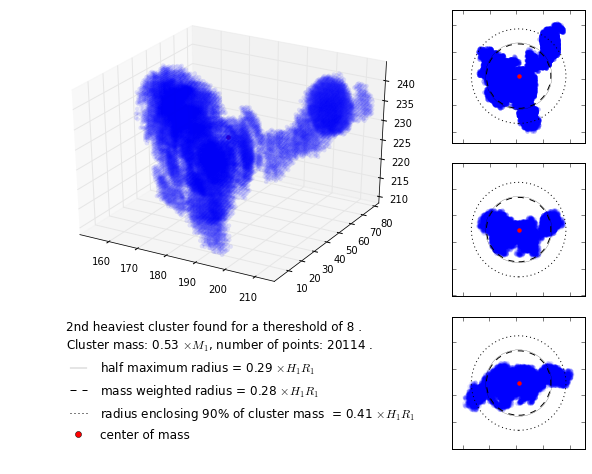

In [201]:
plot_individual_cluster_withprojections(pos,masslabels,1,dapa)

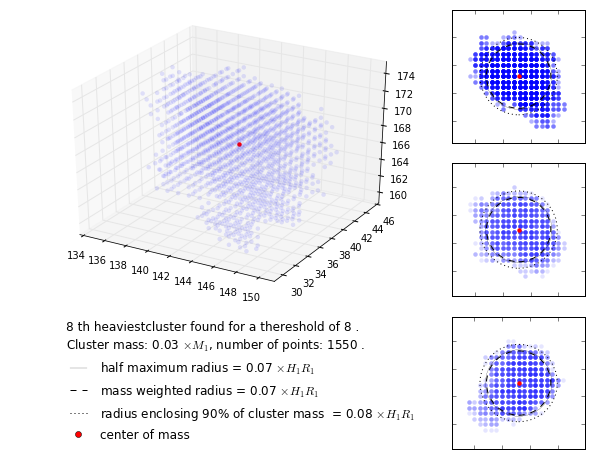

In [206]:
plot_individual_cluster_withprojections(pos,masslabels,7,dapa)

In [222]:
a = np.array([0, 1])
b = np.array([])
c = np.array([0])
if not len(a)==0:
    print('not a')
if not len(b)==0:
    print('not b')
if not len(c)==0:
    print('not c')

not a
not c
